# Statistics on the output data. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import lizard
import subprocess as sub
from pylibsrcml import srcml
import os
import re 
import xml.etree.ElementTree as et 
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv('../data/raspberry_flaw.csv')
dfm = pd.read_csv('../data/raspberry_metrics.csv')

if not os.path.exists("figure"):
    os.mkdir("figure")
df.columns

Index(['Unnamed: 0', 'file', 'line', 'column', 'category', 'name', 'msg',
       'note', 'cwe', 'context', 'helpuri', 'tool', 'defaultlevel', 'level',
       'suggestion', 'fingerprint', 'toolversion', 'ruleid', 'severity',
       'inconclusive'],
      dtype='object')

In [11]:
dfm

,code,isMalicious
0,( strlen ( me ),1
1,*pBuffer = MQTT_PACKET_TYPE_CONNECT ; pBuffer...,1
2,*pBuffer1 = MQTT_PACKET_TYPE_CONNECT1 ; pBuff...,1
3,ActualFreq 1 = cc1ComputeFreq ( DesiredFreq1 ) ;,1
4,ActualFreq = cc1000ComputeFreq ( DesiredFreq ) ;,1
...,...,...
4715,"xResultr = xClass ( xSession , ( char * ) pxLa...",1
4716,"xResultt = xClass ( xSession , ( char * ) pxLa...",1
4717,"xResultw = xClass ( xSession , ( char * ) pxLa...",1
4718,"xResultx = C_Create ( xSessionx, ( A ) & D, si...",1


In [3]:
dfp = df[['category', 'name', 'cwe']].groupby(['category', 'name', 'cwe'], group_keys=False).size().reset_index(name='count')
fig = px.sunburst(dfp, path=['category', 'name', 'cwe'], values='count')
# fig.write_image("figure/vul_statistics.pdf")
fig.show()
dfp.head()

,category,name,cwe,count
0,access,umask,CWE-732,115
1,buffer,bcopy,CWE-120,3
2,buffer,char,CWE-119!/CWE-120,19208
3,buffer,equal,CWE-126,52
4,buffer,fgetc,"CWE-120, CWE-20",19


# Analysis of IoTvulCode tool generated output for feeding non-vul statements:


<AxesSubplot: >

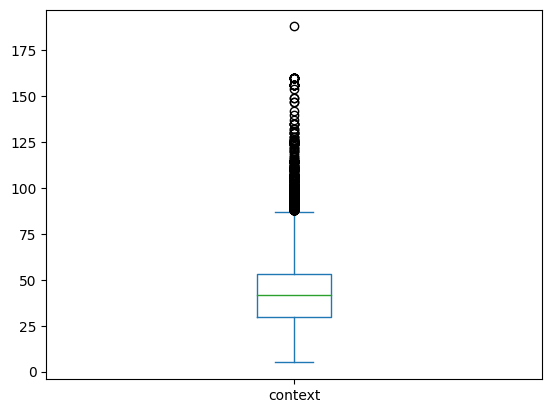

In [4]:
df.context.str.len().sort_values(ascending=False).reset_index(drop=True).plot(kind='box')

In [5]:

import random

def filter_unusual_statements(statements, min_len, max_len):
    """" 
    # https://peps.python.org/pep-0007/
    # https://www.python.org/dev/peps/pep-0007/ 
    """
    filtered_statements = []
    for statement in statements:
        if len(statement) >= min_len and len(statement) <= max_len:
            filtered_statements.append(statement)
   
    # take size of the vul statements as basis
    df = pd.Series(statements)   
    df = df.str.len()
    
    stat_sizes =  list(df[df.between(max_len, min_len)].reset_index(drop=True))
    random.seed(0)
    sample_size = 5 if len(stat_sizes)>5 else len(stat_sizes)-1
    stat_sizes = random.sample(set(stat_sizes), sample_size)
    return stat_sizes


# standard variables:
max_len = 79
# for min_len (eg, 7 characters)
min_len = df.context.str.len().sort_values(ascending=False).reset_index(drop=True).min()


lines = dfm.code[0].splitlines()
stat_sizes = filter_unusual_statements(lines, max_len, min_len)
stat_sizes

[42, 10]

In [17]:
df_dnn = pd.read_csv('../data/iDetect_refine/DNN_Binary.csv')
df_conti = pd.read_csv('../data/contiki-master_Binary.csv')
df_rasp = pd.read_csv('../data/raspberry_metrics.csv')
df_rasp_flaw = pd.read_csv('../data/raspberry_flaw.csv')

print('Shape of DNN data: ', df_dnn.shape)
print('Shape of contiki: ', df_conti.shape)
print('Shape of raspberry: ', df_rasp.shape)
print('Shape of raspberry flaws: ', df_rasp_flaw.shape)

Shape of DNN data:  (4720, 2)
Shape of contiki:  (32889, 2)
Shape of raspberry:  (894715, 14)
Shape of raspberry flaws:  (78136, 20)


In [27]:
df_conti


,code,isMalicious
0,volatile char u2_rx_buf[UART2_RX_BUFFERSIZE-32];,1
1,static char telneticon_textmap[9] = {,1
2,const char http_http[8] =,1
3,const char http_https[9] =,1
4,const char http_200[5] =,1
...,...,...
32884,"if(relation_attribute_add(rel, DB_STORAGE, att...",0
32885,case AQL_TYPE_REMOVE_INDEX:,0
32886,relation's attributes. */,0
32887,result = DB_OK;,0


In [7]:
dfcon = dfcon.rename(columns={'context': 'code'})
dfcon.to_csv('../data/contiki-master_Binary.csv', index=False)

In [8]:
from argparse import ArgumentParser
from configparser import ConfigParser
import yaml
import pandas as pd
from pathlib import Path

def hyperpara2latex(yaml_file):
    """
    load the yaml file and return a dictionary
    """
    config = {}
    cols = ['hyperparameter', 'value']
    
    ext = Path(yaml_file).suffix.replace('.', '') 
    
    
    with open(yaml_file, "r") as stream:
        try:
            config = yaml.safe_load(stream)
            df = pd.DataFrame([config['dnn']]).T.reset_index()
            print(df.to_latex(index=False, 
                    header=cols, 
                    #   column_format='|l|l|', 
                    label='Hyperparameter Settings', 
                    caption='Hyperparameter Settings'))
        except yaml.YAMLError as exc:
            print(exc)

config = hyperpara2latex('../config.yaml')

\begin{table}
\centering
\caption{Hyperparameter Settings}
\label{Hyperparameter Settings}
\begin{tabular}{ll}
\toprule
hyperparameter &                           value \\
\midrule
        epochs &                              50 \\
         batch &                             128 \\
  input\_length &                             150 \\
     input\_dim &                             150 \\
    output\_dim &                              32 \\
            lr &                            1e-4 \\
      patience &                             100 \\
     optimizer &                            adam \\
        l2\_reg &                            1e-4 \\
       dropout &                             0.0 \\
 recur\_dropout &                             0.0 \\
        beta\_1 &                             0.9 \\
        beta\_2 &                           0.999 \\
       epsilon &                           1e-08 \\
         decay &                             0.0 \\
       verbose &                